In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import csv
import pandas as pd
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

Showing if there are GPU device available

In [ ]:
%tensorflow_version 2.x

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


display if the file is correctly placed in datasets folder in your mounted google drive

In [ ]:
file_path="/content/gdrive/My Drive/datasets"
file_names=os.listdir(file_path)
print(file_names)


['emnist-byclass-test.csv', 'emnist-byclass-train.csv']


Loading the data first time for the balanced dataset approach

In [ ]:
train_pd = pd.read_csv('/content/gdrive/My Drive/datasets/emnist-byclass-train.csv',delimiter=",", nrows=90000,header=None)
test_pd = pd.read_csv('/content/gdrive/My Drive/datasets/emnist-byclass-test.csv',delimiter=",", nrows=70000,header=None)

The train dataset distribution overdifferent classes

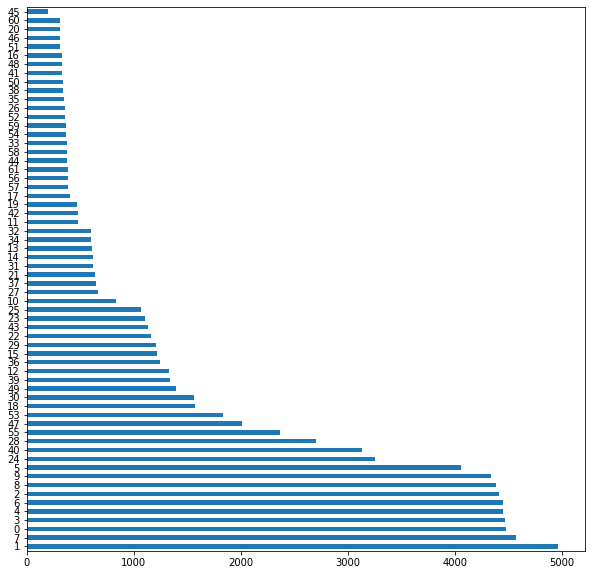

In [ ]:
train_pd.iloc[:,0].value_counts().plot(kind='barh',figsize=(10,10))

Choose the features and the label

In [ ]:
data_train_feature = train_pd.loc[:, "1":"784"].to_numpy()
# Selecting output lable 
data_train_label = train_pd.iloc[:, 0].to_numpy()

data_test_feature = test_pd.loc[:, "1":"784"].to_numpy()
# Selecting output lable 
data_test_label = test_pd.iloc[:, 0].to_numpy()

Oversampling technique to balance the dataset

In [ ]:
from imblearn.over_sampling import SMOTE
over_samples = SMOTE(random_state = 1234)
data_train_f_balance, data_train_l_balance= over_samples.fit_resample(data_train_feature,data_train_label)

Reshape the data to a 28*28 image like ndarray

In [ ]:
data_train_f_balance = data_train_f_balance.reshape((data_train_f_balance.shape[0], 28, 28))
data_test_feature = data_test_feature.reshape((data_test_feature.shape[0], 28, 28))


In [ ]:
print(data_train_f_balance.shape,
data_train_l_balance.shape)

(308016, 28, 28) (308016,)


The train dataset distribution overdifferent classes after oversampling

Text(0, 0.5, 'number of sample')

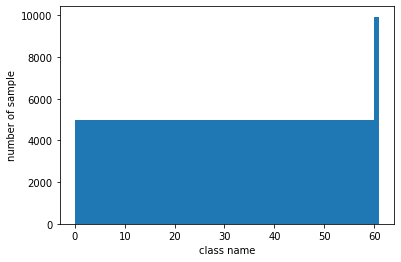

In [ ]:
plt.hist(data_train_l_balance, bins=np.arange(data_train_l_balance.min(), data_train_l_balance.max()+1))
plt.xlabel("class name")
plt.ylabel("number of sample")

CNN model with balanced triaining dataset

expanding the dimension to fit the resnet50 model's requirement and normalise the data.

In [ ]:
data_train_f_balance = np.expand_dims(data_train_f_balance, axis=-1)
# we need 3 channel
data_train_f_balance = np.repeat(data_train_f_balance, 3, axis=-1)
# it's always better to normalize 
data_train_f_balance = data_train_f_balance.astype('float32') / 255

data_test_feature = np.expand_dims(data_test_feature, axis=-1)
# we need 3 channel
data_test_feature = np.repeat(data_test_feature, 3, axis=-1)
# it's always better to normalize 
data_test_feature = data_test_feature.astype('float32') / 255

In [ ]:
print(data_train_f_balance.shape,
data_train_l_balance.shape,
)

(308016, 28, 28, 3) (308016,)


train test spliting and convert the ndarray to tensor.
apply the resize function from tensorflow and make it to fit the minimum requirement for resnet50 model's input image size.

In [ ]:
X_train_b, X_valid_b, y_train_b, y_valid_b = train_test_split(data_train_f_balance,data_train_l_balance,random_state=0)

#convert x_train to tensor then resize
X_train_b = tf.convert_to_tensor(X_train_b)
X_train_b= tf.image.resize(X_train_b, [32,32])

#convert x_valid to tensor then resize
X_valid_b = tf.convert_to_tensor(X_valid_b)
X_valid_b= tf.image.resize(X_valid_b, [32,32])

data_test_feature = tf.convert_to_tensor(data_test_feature)
data_test_feature=tf.image.resize(data_test_feature, [32,32])

In [ ]:
print(tf.shape(X_train_b),tf.shape(X_valid_b))

tf.Tensor([231012     32     32      3], shape=(4,), dtype=int32) tf.Tensor([77004    32    32     3], shape=(4,), dtype=int32)


defining the input and earlystopping of the model.

In [ ]:
from tensorflow.keras.applications import ResNet50
input_t = Input(shape=(32,32,3))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

resenet50 model creation with no pre-train weight

In [ ]:
def creat_model(input_t):
  res_model=ResNet50(include_top=False,weights=None, input_tensor = input_t)
  base_model = Sequential()
  base_model.add(res_model)
  base_model.add(Flatten())
  base_model.add(BatchNormalization())
  base_model.add(Dense(256, activation='relu'))
  base_model.add(Dropout(0.5))
  base_model.add(BatchNormalization())
  base_model.add(Dense(128, activation='relu'))
  base_model.add(Dropout(0.5))
  base_model.add(Dense(62, activation='softmax'))
  return base_model

use the same parameter as the imblanaced dataset's turning down below in hyperparameter turning of the ResNet50 on imbalanced dataset,since we want to compare the model on balanced dataset and imbalanced dataset on same parameter.

In [ ]:
base_model_b=creat_model(input_t)
base_model_b.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])
  #fit the model and train
history = base_model_b.fit(X_train_b,y_train_b,batch_size=128,epochs=15,validation_data=(X_valid_b,y_valid_b),callbacks=[callback])
loss, accuracy = base_model_b.evaluate(data_test_feature, data_test_label)
print(f"Accuracy on test data: {accuracy:.4f}")

Epoch 1/15
1805/1805 [==============================] - 104s 54ms/step - loss: 1.1590 - accuracy: 0.6137 - val_loss: 0.7169 - val_accuracy: 0.7199
Epoch 2/15
1805/1805 [==============================] - 98s 54ms/step - loss: 0.6246 - accuracy: 0.7531 - val_loss: 0.6438 - val_accuracy: 0.7534
Epoch 3/15
1805/1805 [==============================] - 99s 55ms/step - loss: 0.5537 - accuracy: 0.7811 - val_loss: 0.5149 - val_accuracy: 0.7835
Epoch 4/15
1805/1805 [==============================] - 98s 54ms/step - loss: 0.5144 - accuracy: 0.7956 - val_loss: 0.6522 - val_accuracy: 0.7545
Epoch 5/15
1805/1805 [==============================] - 98s 54ms/step - loss: 0.4698 - accuracy: 0.8164 - val_loss: 0.4968 - val_accuracy: 0.8050
Epoch 6/15
1805/1805 [==============================] - 97s 54ms/step - loss: 0.4222 - accuracy: 0.8371 - val_loss: 0.4100 - val_accuracy: 0.8383
Epoch 7/15
1805/1805 [==============================] - 97s 54ms/step - loss: 0.3724 - accuracy: 0.8588 - val_loss: 0.3420 

In [ ]:
from sklearn.metrics import classification_report
y_pred = base_model_b.predict(data_test_feature, batch_size=128)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(data_test_label, y_pred_bool))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71      3461
           1       0.70      0.73      0.71      3860
           2       0.96      0.95      0.95      3559
           3       0.99      0.99      0.99      3577
           4       0.97      0.95      0.96      3411
           5       0.94      0.92      0.93      3115
           6       0.97      0.96      0.96      3426
           7       0.98      0.99      0.98      3768
           8       0.95      0.98      0.97      3375
           9       0.91      0.96      0.94      3390
          10       0.93      0.94      0.93       647
          11       0.94      0.92      0.93       395
          12       0.80      0.78      0.79      1080
          13       0.79      0.91      0.84       446
          14       0.93      0.96      0.94       521
          15       0.79      0.67      0.72       874
          16       0.84      0.87      0.86       254
          17       0.88    

CNN model with inbalanced training dataset

Load same amount of data as the oversampling dataset numbers

In [ ]:
train_pd_in = pd.read_csv('/content/gdrive/My Drive/datasets/emnist-byclass-train.csv',delimiter=",", nrows=308016,header=None)


Select features and label

In [ ]:
data_train_feature = train_pd_in.loc[:, "1":"784"].to_numpy()
# Selecting output lable 
data_train_label = train_pd_in.iloc[:, 0].to_numpy()


In [ ]:
data_train_feature = data_train_feature.reshape((data_train_feature.shape[0], 28, 28))
data_train_feature.shape

(308016, 28, 28)

expanding the dimension

In [ ]:

data_train_feature = np.expand_dims(data_train_feature, axis=-1)
# we need 3 channel
data_train_feature = np.repeat(data_train_feature, 3, axis=-1)
# it's always better to normalize 
data_train_feature = data_train_feature.astype('float32') / 255


Convert image to tensor then resize them to 32*32

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data_train_feature,data_train_label,random_state=0)

#convert x_train to tensor then resize
X_train = tf.convert_to_tensor(X_train)
X_train= tf.image.resize(X_train, [32,32])

#convert x_valid to tensor then resize
X_valid = tf.convert_to_tensor(X_valid)
X_valid= tf.image.resize(X_valid, [32,32])


In [ ]:
print(tf.shape(X_train),tf.shape(X_valid))

tf.Tensor([231012     32     32      3], shape=(4,), dtype=int32) tf.Tensor([77004    32    32     3], shape=(4,), dtype=int32)


In [ ]:
from tensorflow.keras.applications import ResNet50
input_t = Input(shape=(32,32,3))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Hyperparameter turning on learning rate of Adam optimizer and the batch size 

In [ ]:
learning_rate=[1e-2,1e-3]
batch=[128,256]
result=[]
result_history=[]

def model_turning(lr,bs,base_model):
  base_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                metrics=['accuracy'])
  #fit the model and train
  history = base_model.fit(X_train,y_train,batch_size=bs,epochs=10,validation_data=(X_valid,y_valid),callbacks=[callback])
  loss, accuracy = base_model.evaluate(data_test_feature, data_test_label)
  print(f"Accuracy on test data: {accuracy:.4f}")
  return accuracy,lr,bs,history

for i in range(len(learning_rate)):
  for j in range(len(batch)):
    model=creat_model(input_t)
    print('learning rate:{} batch size: {}'.format(learning_rate[i],batch[j]))
    model_result= model_turning(learning_rate[i],batch[j],model)
    result_history.append(model_result[3])
    result.append((model_result[0],model_result[1],model_result[2]))

learning rate:0.01 batch size: 128
Epoch 1/10
1805/1805 [==============================] - 108s 57ms/step - loss: 1.1358 - accuracy: 0.6690 - val_loss: 1.0500 - val_accuracy: 0.6985
Epoch 2/10
1805/1805 [==============================] - 101s 56ms/step - loss: 0.7017 - accuracy: 0.7835 - val_loss: 0.5910 - val_accuracy: 0.8118
Epoch 3/10
1805/1805 [==============================] - 102s 56ms/step - loss: 0.6558 - accuracy: 0.7979 - val_loss: 0.9398 - val_accuracy: 0.7469
Epoch 4/10
1805/1805 [==============================] - 101s 56ms/step - loss: 0.6324 - accuracy: 0.8040 - val_loss: 0.5620 - val_accuracy: 0.8148
Epoch 5/10
1805/1805 [==============================] - 102s 56ms/step - loss: 0.6240 - accuracy: 0.8087 - val_loss: 0.5889 - val_accuracy: 0.8216
Epoch 6/10
1805/1805 [==============================] - 102s 56ms/step - loss: 0.6036 - accuracy: 0.8124 - val_loss: 0.5974 - val_accuracy: 0.8119
Epoch 7/10
1805/1805 [==============================] - 101s 56ms/step - loss: 0.58

showing all the result and find best parameter

In [ ]:
for item in result:
  print(item[0],item[1],item[2])

0.8442714214324951 0.01 128
0.8399571180343628 0.01 256
0.8605571389198303 0.001 128
0.8532857298851013 0.001 256


Model with best hyperparameter

In [ ]:
base_model=creat_model(input_t)
base_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001 ),
                metrics=['accuracy'])
  #fit the model and train
history = base_model.fit(X_train,y_train,batch_size=128,epochs= 15,validation_data=(X_valid,y_valid),callbacks=[callback])
loss, accuracy = base_model.evaluate(data_test_feature, data_test_label)
print(f"Accuracy on test data: {accuracy:.4f}")

Epoch 1/15
1805/1805 [==============================] - 105s 55ms/step - loss: 1.0338 - accuracy: 0.7140 - val_loss: 0.6012 - val_accuracy: 0.8028
Epoch 2/15
1805/1805 [==============================] - 98s 54ms/step - loss: 0.5678 - accuracy: 0.8189 - val_loss: 0.5038 - val_accuracy: 0.8215
Epoch 3/15
1805/1805 [==============================] - 98s 55ms/step - loss: 0.5256 - accuracy: 0.8293 - val_loss: 0.4980 - val_accuracy: 0.8356
Epoch 4/15
1805/1805 [==============================] - 98s 54ms/step - loss: 0.4998 - accuracy: 0.8354 - val_loss: 0.4699 - val_accuracy: 0.8381
Epoch 5/15
1805/1805 [==============================] - 97s 54ms/step - loss: 0.4806 - accuracy: 0.8402 - val_loss: 0.4788 - val_accuracy: 0.8334
Epoch 6/15
1805/1805 [==============================] - 97s 54ms/step - loss: 0.4616 - accuracy: 0.8454 - val_loss: 0.4223 - val_accuracy: 0.8511
Epoch 7/15
1805/1805 [==============================] - 97s 54ms/step - loss: 0.4444 - accuracy: 0.8495 - val_loss: 0.4638 

In [ ]:
from sklearn.metrics import classification_report
y_pred = base_model.predict(data_test_feature, batch_size=128)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(data_test_label, y_pred_bool))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      3461
           1       0.65      0.96      0.77      3860
           2       0.96      0.98      0.97      3559
           3       0.99      0.99      0.99      3577
           4       0.97      0.97      0.97      3411
           5       0.96      0.92      0.94      3115
           6       0.97      0.98      0.97      3426
           7       0.99      0.99      0.99      3768
           8       0.98      0.99      0.98      3375
           9       0.93      0.98      0.96      3390
          10       0.92      0.98      0.95       647
          11       0.94      0.93      0.94       395
          12       0.77      0.97      0.86      1080
          13       0.96      0.83      0.89       446
          14       0.95      0.97      0.96       521
          15       0.75      0.98      0.85       874
          16       0.85      0.95      0.90       254
          17       0.94    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Save the model

In [ ]:
base_model.save('my_model.h5')

In [ ]:
from google.colab import files
files.download('/content/my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

System information

In [ ]:
!cat /proc/cpuinfo
!cat /proc/meminfo
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8467891350589682677
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17322349674500832609
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]